# Extending Ibis Part 2: Adding a New Reduction Expression

This notebook will show you how to add a new *reduction* operation (`bitwise_and`) to an existing backend (PostgreSQL).

A reduction operation is a function that maps $N$ rows to 1 row, for example the `sum` function.

## Description

We're going to add a **`bitwise_and`** function to ibis. `bitwise_and` computes the logical `AND` of the individual bits of an integer.

For example,

```
  0101
  0111
  0011
& 1101
------
  0001
```

## Step 1: Define the Operation

Let's define the `bitwise_and` operation as a function that takes any integer typed column as input and returns an integer

```haskell
bitwise_and :: Column Int -> Int
```

In [1]:
import ibis.expr.datatypes as dt
import ibis.expr.rules as rlz

from ibis.expr.operations import Reduction, Arg


class BitwiseAnd(Reduction):
    arg = Arg(rlz.column(rlz.integer))
    where = Arg(rlz.boolean, default=None)
    output_type = rlz.scalar_like('arg')

We just defined a `BitwiseAnd` class that takes one integer column as input, and returns a scalar output of the same type as the input. This matches both the requirements of a reduction and the spepcifics of the function that we want to implement.

**Note**: It is very important that you write the correct argument rules and output type here. The expression *will not work* otherwise.

## Step 2: Define the API

Because every reduction in ibis has the ability to filter out values during aggregation (a typical feature in databases and analytics tools), to make an expression out of ``BitwiseAnd`` we need to pass an additional argument: `where` to our `BitwiseAnd` constructor.

In [2]:
from ibis.expr.types import IntegerColumn  # not IntegerValue! reductions are only valid on columns


def bitwise_and(integer_column, where=None):
    return BitwiseAnd(integer_column, where=where).to_expr()


IntegerColumn.bitwise_and = bitwise_and

## Interlude: Create some expressions using `bitwise_and`

In [3]:
import ibis

In [4]:
t = ibis.table([('bigint_col', 'int64'), ('string_col', 'string')], name='t')

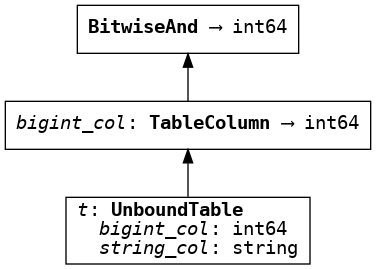

In [5]:
t.bigint_col.bitwise_and()

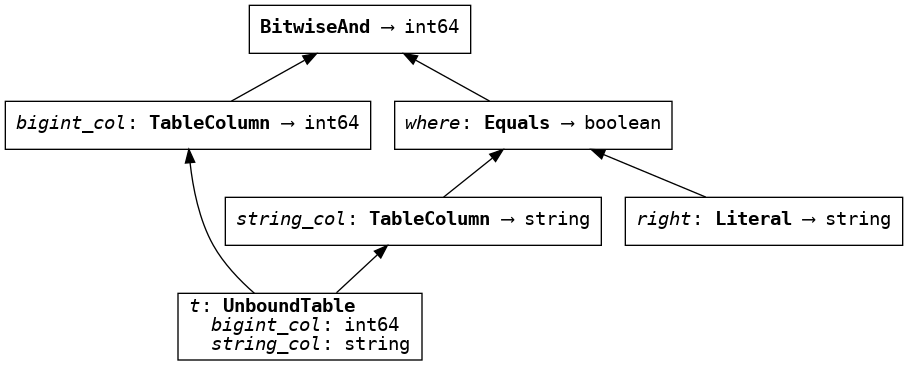

In [6]:
t.bigint_col.bitwise_and(t.string_col == '1')

## Step 3: Turn the Expression into SQL

In [7]:
import sqlalchemy as sa


@ibis.postgres.compiles(BitwiseAnd)
def compile_sha1(translator, expr):
    # pull out the arguments to the expression
    arg, where = expr.op().args
    
    # compile the argument
    compiled_arg = translator.translate(arg)
    
    # call the appropriate postgres function
    agg = sa.func.bit_and(compiled_arg)
    
    # handle a non-None filter clause
    if where is not None:
        return agg.filter(translator.translate(where))
    return agg

## Step 4: Putting it all Together

### Connect to the `ibis_testing` database

**NOTE:**

To be able to execute the rest of this notebook you need to run the following command from your ibis clone:

```sh
make init
```

In [8]:
con = ibis.postgres.connect(
    user='postgres',
    host='postgres',
    password='postgres',
    database='ibis_testing'
)

### Create and execute a `bitwise_and` expression

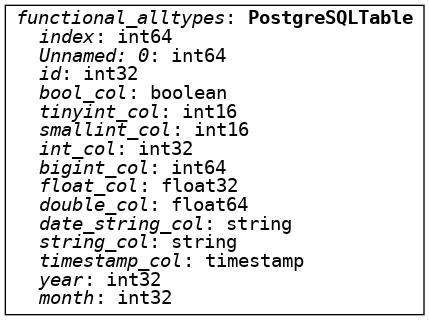

In [9]:
t = con.table('functional_alltypes')
t

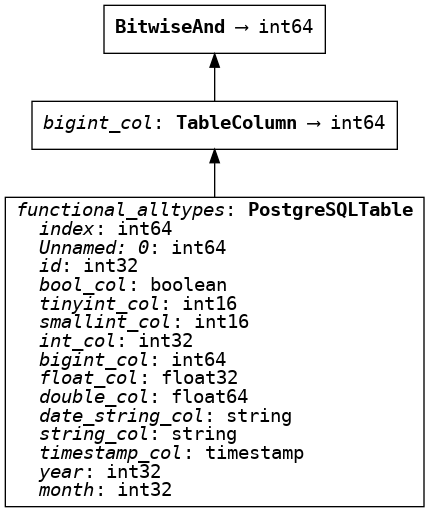

In [10]:
expr = t.bigint_col.bitwise_and()
expr

In [11]:
sql_expr = expr.compile()
print(sql_expr)

SELECT bit_and(t0.bigint_col) AS tmp 
FROM functional_alltypes AS t0


In [12]:
expr.execute()

0

### Let's see what a `bitwise_and` call looks like with a `where` argument

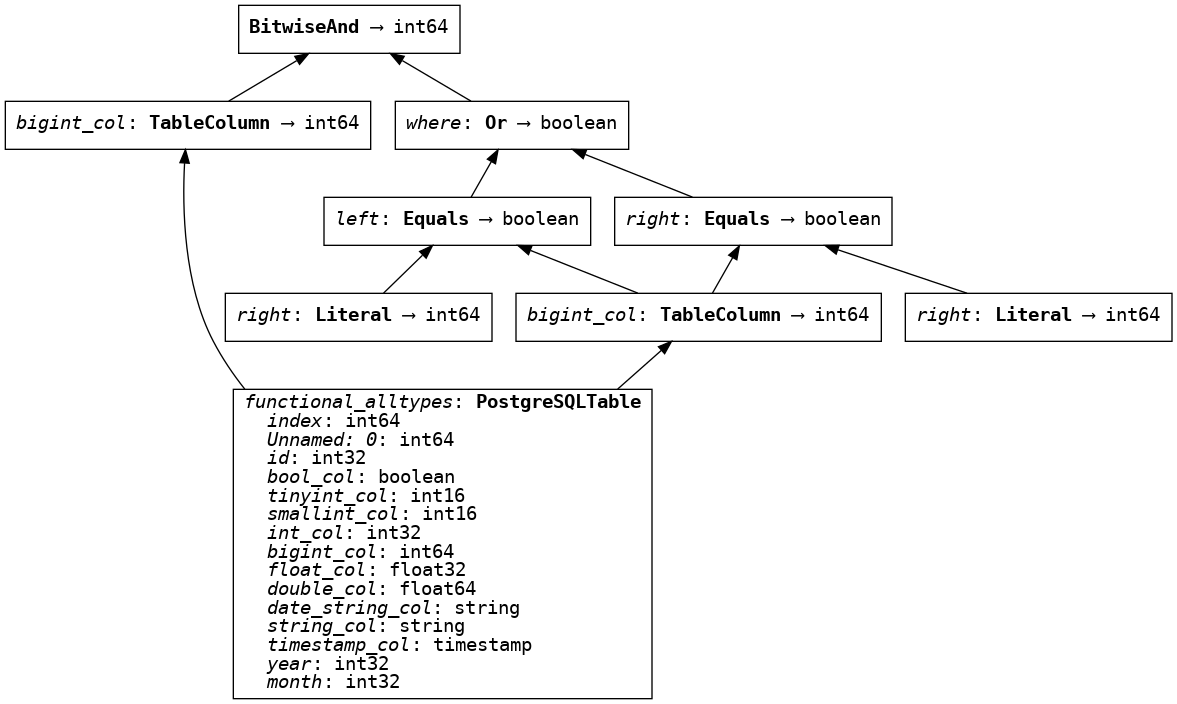

In [13]:
expr = t.bigint_col.bitwise_and(where=(t.bigint_col == 10) | (t.bigint_col == 40))
expr

In [14]:
result = expr.execute()
result

8

### Let's confirm that taking bitwise `AND` of 10 and 40 is in fact 8

In [15]:
10 & 40

8

In [16]:
print('  {:0>8b}'.format(10))
print('& {:0>8b}'.format(40))
print('-' * 10)
print('  {:0>8b}'.format(10 & 40))

  00001010
& 00101000
----------
  00001000
